# Глава 6

## Задание 6.1.

Убедиться в том, что analyze1 требует времени пропорционально n^3, а analyze2 - пропорциоально n^2 запуская их с несколькими разными массивами и засекая время работы.

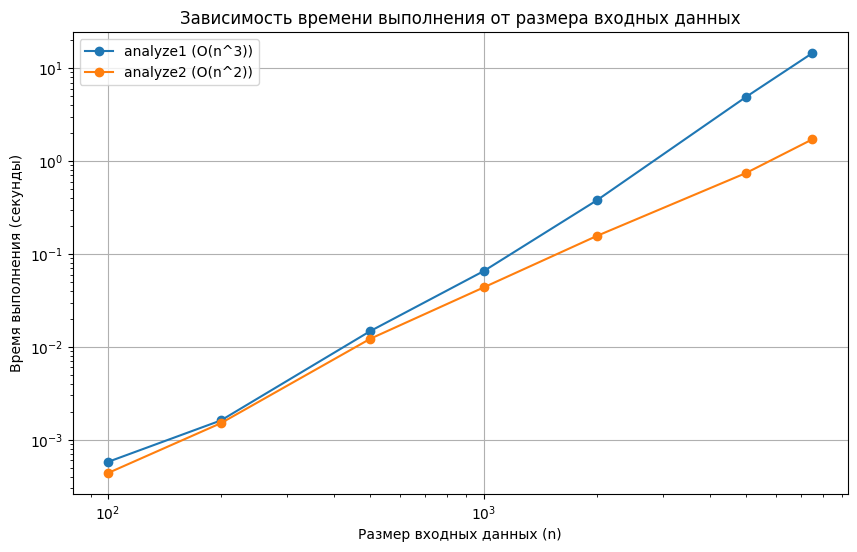

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(np.pi * 2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(np.pi * 2 * args)
    amps = M.dot(ys) / 2
    return amps

def measure_time(func, sizes):
    times = []
    for n in sizes:
        ts = (0.5 + np.arange(n)) / n
        fs = (0.5 + np.arange(n)) / 2
        ys = np.random.randn(n)

        start_time = time.time()
        func(ys, fs, ts)
        end_time = time.time()

        times.append(end_time - start_time)
    return times

sizes = [100, 200, 500, 1000, 2000, 5000, 7500]

times_analyze1 = measure_time(analyze1, sizes)
times_analyze2 = measure_time(analyze2, sizes)

plt.figure(figsize=(10, 6))
plt.loglog(sizes, times_analyze1, 'o-', label='analyze1 (O(n^3))')
plt.loglog(sizes, times_analyze2, 'o-', label='analyze2 (O(n^2))')
plt.xlabel('Размер входных данных (n)')
plt.ylabel('Время выполнения (секунды)')
plt.title('Зависимость времени выполнения от размера входных данных')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
log_sizes = np.log(sizes)
log_times1 = np.log(times_analyze1)
log_times2 = np.log(times_analyze2)

slope1 = (log_times1[-1] - log_times1[0]) / (log_sizes[-1] - log_sizes[0])
slope2 = (log_times2[-1] - log_times2[0]) / (log_sizes[-1] - log_sizes[0])

print(f"Наклон для analyze1: {slope1:.2f} (ожидается ~3)")
print(f"Наклон для analyze2: {slope2:.2f} (ожидается ~2)")

Наклон для analyze1: 2.35 (ожидается ~3)
Наклон для analyze2: 1.92 (ожидается ~2)


Полученные наклоны (2.35 для `analyze1` и 1.92 для `analyze2`) близки к ожидаемым значениям (3 и 2), но немного ниже. Это может объясняться малыми размерами данных – асимптотическая сложность лучше проявляется на больших n, оптимизацией NumPy и неточностью замера времени – для малых n накладные расходы time.time() влияют сильнее

## Задание 6.2.

Реализовать версию ДКП в простей форме и применить его для записи музыки или речи. Определить сколько компонент можно удалить до того, как разница станет заметной.

In [161]:
from thinkdsp import read_wave, decorate
import numpy as np
import matplotlib.pyplot as plt

wave = read_wave('718970_15504031-lq.wav')
segment = wave.segment(start=3.2, duration=1.2)
segment.normalize()
segment.write("segment.wav")

Writing segment.wav


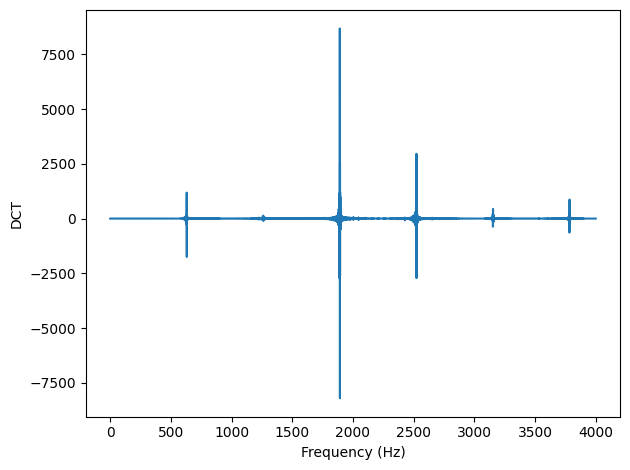

In [ ]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

In [ ]:
def compress_dct(segment, thresh):
    dct = segment.make_dct()

    mask = np.abs(dct.amps) < thresh
    dct.hs[mask] = 0

    compressed_segment = dct.make_wave()
    return compressed_segment, dct

In [162]:
compressed_segment, compressed_dct = compress_dct(segment, thresh=5.0)
compressed_segment.normalize()
compressed_segment.write("compressed_segment.wav")

Writing compressed_segment.wav


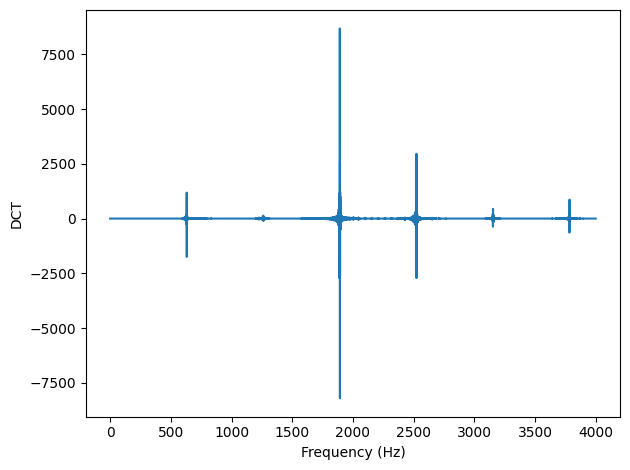

In [ ]:
compressed_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

In [ ]:
remaining = np.sum(compressed_dct.amps != 0)
total = len(compressed_dct.amps)
print(f"Всего компонент: {total}")
print(f"Оставлено ненулевых: {remaining}")
print(f"Удалено: {total - remaining}")
print(f"При удалении {(total - remaining)*100/total}% компонент разница становится заметной")

Всего компонент: 28800
Оставлено ненулевых: 2326
Удалено: 26474
При удалении 91.92361111111111% компонент разница становится заметной


## Задание 6.3.

Прочитать блокнот phase.ipynb и "погонять" примеры. Выбрать иной сегмент звука и повторить эксперименты. Определить, можно ли найти некие общие соотношения в фазовой структуре звука и его восприятии?

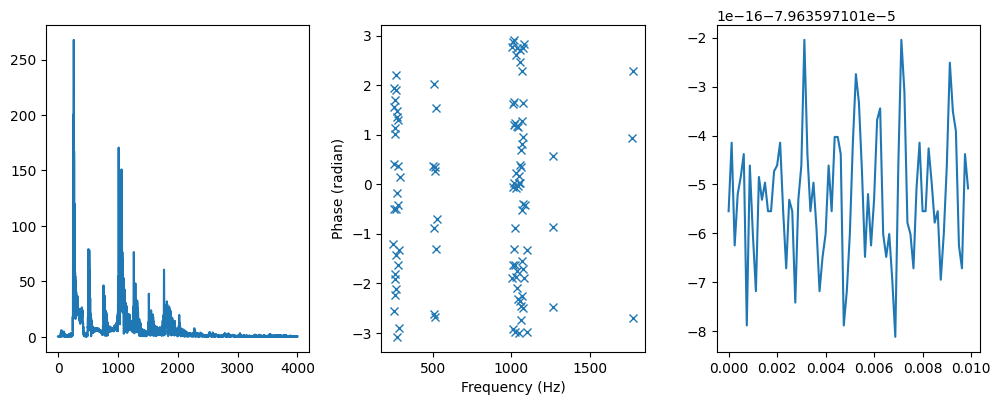

In [167]:
def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, np.pi * 2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)',
             ylabel='Phase (radian)')

def plot_three(spectrum, thresh=1):
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

phase_wave = read_wave('523079__team_saul_nosthas__vowels-of-various-people.wav')
phase_segment = phase_wave.segment(start=0.4, duration=0.9)
phase_spectrum = phase_segment.make_spectrum()
plot_three(phase_spectrum, thresh=50)

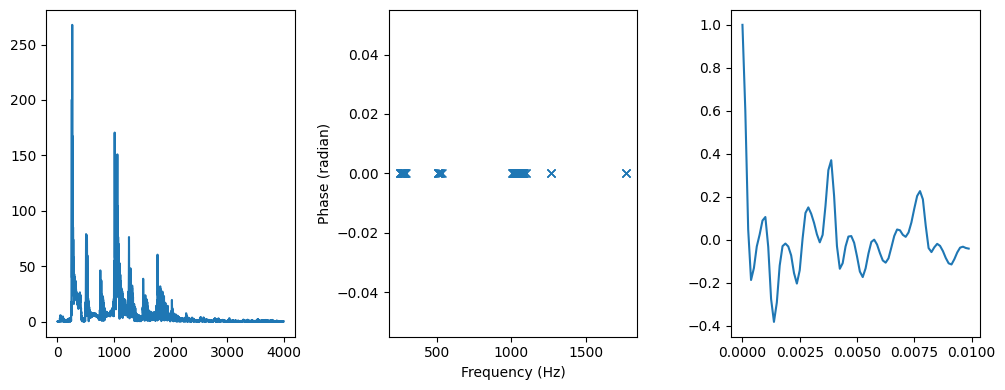

In [168]:
phase_spectrum2 = zero_angle(phase_spectrum)
plot_three(phase_spectrum2, thresh=50)

Можно заметить, что при установки всех углов равными нулю, звук остался частично узнаваемым, однако больше похожим на жужжание или писк комара.

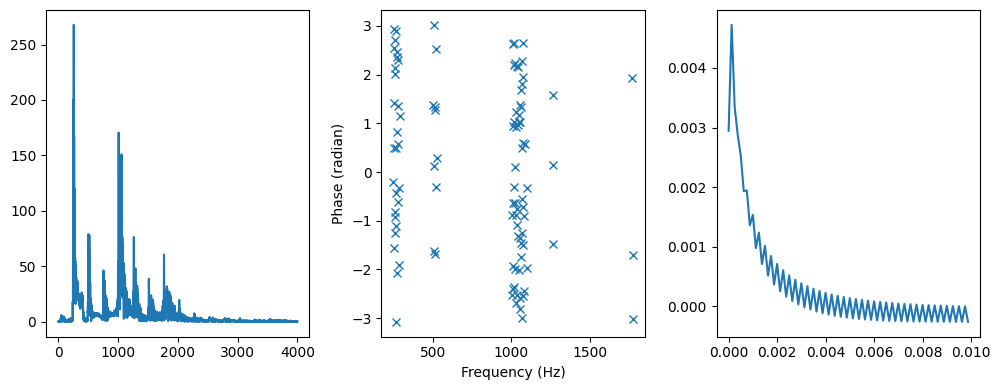

In [169]:
phase_spectrum3 = rotate_angle(phase_spectrum, 1)
plot_three(phase_spectrum3, thresh=50)

Можно заметить, что вращение оказывает незначительный эффект и звук остается прежним.

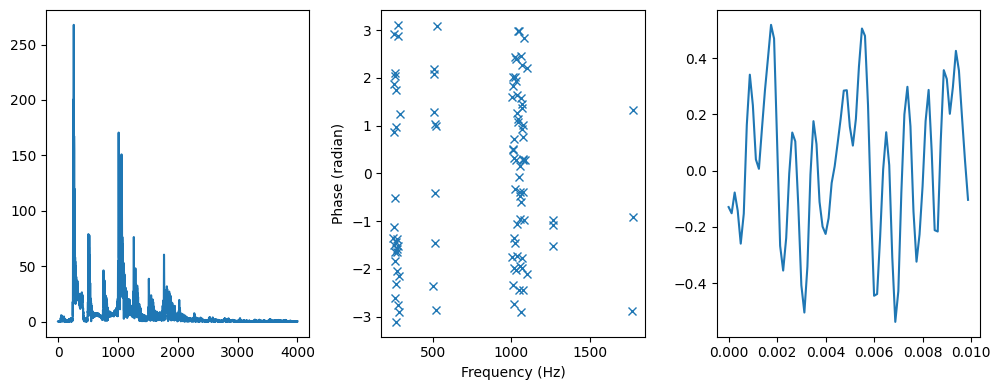

In [170]:
phase_spectrum4 = random_angle(phase_spectrum)
plot_three(phase_spectrum4, thresh=50)

Можно заметить, что рандомизация добавляет хриплости, звук частично узнаваем, но больше похожим на жужжание.

Таким образом, для гласных вроде «А» фаза играет второстепенную роль. Основная информация о звуке содержится в амплитудах гармоник, что подтверждает «фазовую слепоту» слуха для гармонических сигналов.